In [1]:
import numpy as np
from torch import nn
from torch.nn import functional as F
import torch
from torch import optim
from torchvision import datasets,transforms
from torchinfo import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2

from transformations import (train_transforms,test_transforms,no_transforms)

from trainer import Trainer
from tester import Tester
from utlis import visualize_data,show_misclassified_images,device,is_cuda
from viz import plot_class_distribution, plot_confusion_matrix, plot_curves
from dataloader import CIFAR10Dataset,CIFAR10DataLoader
from models import ConvLayer,TransBlock,DepthwiseConvLayer


# Augmentation
atrain_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=train_transforms,download=False)
atest_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
acifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
atrain_loader, atest_loader = acifar.get_loader(atrain_dataset,atest_dataset)


# No Augmentation
train_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=test_transforms,download=False)
test_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
cifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
train_loader, test_loader = cifar.get_loader(train_dataset,test_dataset)

C:\Users\muthu\Documents\TSAI\session 9\utlis.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


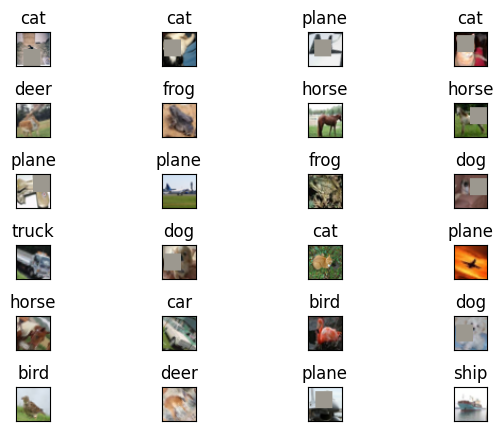

In [2]:
visualize_data(atrain_loader,classes=acifar.classes,num_figures=24)

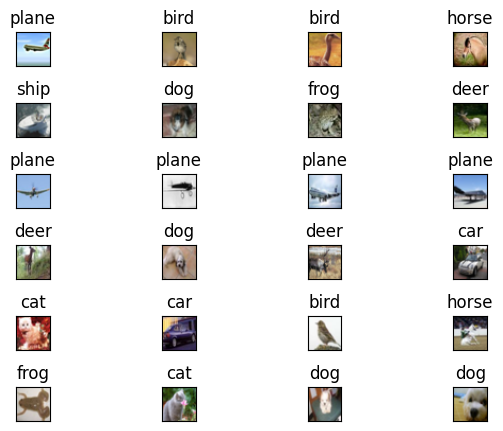

In [3]:
visualize_data(train_loader,classes=cifar.classes,num_figures=24,)

In [9]:
dp_rate = 0.01
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = ConvLayer(inc=3,outc=24,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.trans1 = TransBlock(inc=24,outc=62,p=0)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = nn.Sequential(TransBlock(inc=62,outc=10,p=0))
    def forward(self,x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.out(self.gap(x))
        return  F.log_softmax(x.view(-1,10), dim=1)

model = Net()

In [10]:
summary(model=model,input_size=(1,3,32,32),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─ConvLayer: 1-1                         [1, 24, 32, 32]           --
│    └─Sequential: 2-1                   [1, 24, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 24, 32, 32]           648
│    │    └─BatchNorm2d: 3-2             [1, 24, 32, 32]           48
│    │    └─ReLU: 3-3                    [1, 24, 32, 32]           --
│    │    └─Dropout2d: 3-4               [1, 24, 32, 32]           --
├─TransBlock: 1-2                        [1, 62, 32, 32]           --
│    └─Sequential: 2-2                   [1, 62, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 62, 32, 32]           1,488
├─AdaptiveAvgPool2d: 1-3                 [1, 62, 1, 1]             --
├─Sequential: 1-4                        [1, 10, 1, 1]             --
│    └─TransBlock: 2-3                   [1, 10, 1, 1]             --
│    │    └

In [ ]:
prev_test_loss = float('inf')

optimizer = optim.SGD(params=model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model, test_loader=test_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model.state_dict(),f='./bmodels/model.pth')
    scheduler.step(test_loss)

In [ ]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

In [ ]:
images, predictions, labels =  tester.get_misclassified_images()

In [ ]:
show_misclassified_images(images[:15],predictions[:15],labels[:15],cifar.classes)

In [ ]:
plot_class_distribution(train_loader,cifar.classes)

In [ ]:
plot_confusion_matrix(model,test_loader,device,cifar.classes)